C:\ProgramData\Anaconda2\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


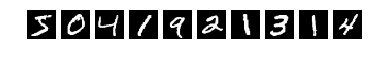

label: [5 0 4 1 9 2 1 3 1 4]


In [1]:
import numpy as np
import os
import gzip
import struct
import logging
import mxnet as mx
import matplotlib.pyplot as plt # 这是常用的绘图库
logging.getLogger().setLevel(logging.DEBUG)

def read_data(label_url, image_url): # 读入训练数据
    with gzip.open(label_url) as flbl: # 打开标签文件
        magic, num = struct.unpack(">II", flbl.read(8)) # 读入标签文件头
        label = np.fromstring(flbl.read(), dtype=np.int8) # 读入标签内容
    with gzip.open(image_url, 'rb') as fimg: # 打开图像文件
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16)) # 读入图像文件头，rows和cols都会是28
        image = np.fromstring(fimg.read(), dtype=np.uint8) # 读入图像内容
        image = image.reshape(len(label), 1, rows, cols) # 设置为正确的数组格式
        image = image.astype(np.float32)/255.0 # 归一化为0到1区间
    return (label, image)

# 读入数据
(train_lbl, train_img) = read_data('train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data('t10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz')
 
batch_size = 32 # 批大小

# 迭代器
train_iter = mx.io.NDArrayIter(train_img, train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(val_img, val_lbl, batch_size)  

for i in range(10): # 输出前10个数字
    plt.subplot(1,10,i+1) # 这里的语句可参见matplotlib库的介绍
    plt.imshow(train_img[i].reshape(28,28), cmap='Greys_r') # 新版 matplotlib 需要这样 reshape
    plt.axis('off')
plt.show() # 显示图像
print('label: %s' % (train_lbl[0:10],)) # 显示对应的标签

In [2]:
data = mx.symbol.Variable('data')

# 将图像摊平，例如1*28*28的图像会变为784个数据点，这样才可与普通神经元连接
flatten = mx.sym.Flatten(data=data, name="flatten")

# 第1层网络及非线性激活，有128个神经元，使用ReLU非线性
fc1  = mx.sym.FullyConnected(data=flatten, num_hidden=128, name="fc1")
act1 = mx.sym.Activation(data=fc1, act_type="relu", name="act1")

# 第2层网络及非线性激活，有64个神经元，使用ReLU非线性
fc2  = mx.sym.FullyConnected(data=act1, num_hidden=64, name="fc2")
act2 = mx.sym.Activation(data=fc2, act_type="relu", name="act2")
    
# 输出神经元，因为需分为10类，所以有10个神经元
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=10, name="fc3")
# SoftMax层，将上一层输出的10个数变为10个分类的概率
net  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# 我们将调用MXNet中的viz库，需要先告知MXNet输入数据的格式
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.print_summary(symbol=net, shape=shape)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          1x28x28                 0                                           
________________________________________________________________________________________________________________________
flatten(Flatten)                                    784                     0           data                            
________________________________________________________________________________________________________________________
fc1(FullyConnected)                                 128                     100480      flatten                         
________________________________________________________________________________________________________________________
act1(Activation)                

In [3]:
mx.viz.plot_network(symbol=net, shape=shape).view() # 注意需安装 Graphviz

'plot.gv.pdf'

In [4]:
# 由于训练数据量较大，这里采用了GPU，若读者没有GPU，可修改为CPU
module = mx.mod.Module(symbol=net, context=mx.gpu(0))

module.fit(
    train_iter,
    eval_data=val_iter,
    optimizer = 'sgd',
# 采用0.2的初始学习速率，并在每60000个样本后（即每1个epoch后）将学习速率缩减为之前的0.9倍
    optimizer_params = {'learning_rate' : 0.2, 'lr_scheduler' : mx.lr_scheduler.FactorScheduler(step=60000/batch_size, factor=0.9)},
    num_epoch = 20,
    batch_end_callback = mx.callback.Speedometer(batch_size, 60000/batch_size)
)

INFO:root:Epoch[0] Train-accuracy=0.744050
INFO:root:Epoch[0] Time cost=1.702
INFO:root:Epoch[0] Validation-accuracy=0.950978
INFO:root:Update[1876]: Change learning rate to 1.80000e-01
INFO:root:Epoch[1] Train-accuracy=0.959167
INFO:root:Epoch[1] Time cost=1.641
INFO:root:Epoch[1] Validation-accuracy=0.968950
INFO:root:Update[3751]: Change learning rate to 1.62000e-01
INFO:root:Epoch[2] Train-accuracy=0.974550
INFO:root:Epoch[2] Time cost=1.662
INFO:root:Epoch[2] Validation-accuracy=0.974441
INFO:root:Update[5626]: Change learning rate to 1.45800e-01
INFO:root:Epoch[3] Train-accuracy=0.982233
INFO:root:Epoch[3] Time cost=1.674
INFO:root:Epoch[3] Validation-accuracy=0.975739
INFO:root:Update[7501]: Change learning rate to 1.31220e-01
INFO:root:Epoch[4] Train-accuracy=0.987150
INFO:root:Epoch[4] Time cost=1.653
INFO:root:Epoch[4] Validation-accuracy=0.977236
INFO:root:Update[9376]: Change learning rate to 1.18098e-01
INFO:root:Epoch[5] Train-accuracy=0.990767
INFO:root:Epoch[5] Time cos